In [2]:
import pandas as pd
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt

# Carregar o arquivo CSV
file_path = "./analog_squaring.csv"  # Substitua pelo caminho correto
data = pd.read_csv(file_path)

# Remover espaços extras nos nomes das colunas
data.columns = data.columns.str.strip()

# Converter para o sistema internacional (já está em volts)
data["U_1^2 (V^2)"] = data["U_1 (V)"]**2  # Converter U_1^2 para mV^2

Equação da Regressão Linear: y = 1.10e-01 * x + 3.80e-05
Coeficiente de Determinação (R²): 0.9996
Erro Padrão: 0.0005
P-valor: 8.350e-29


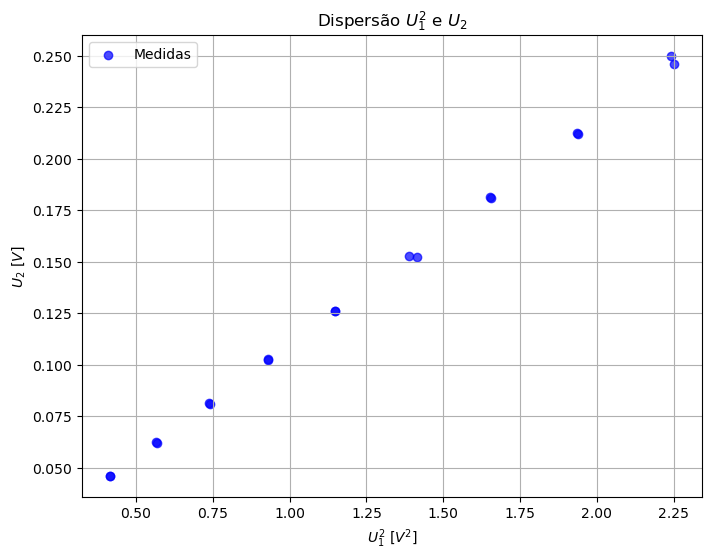

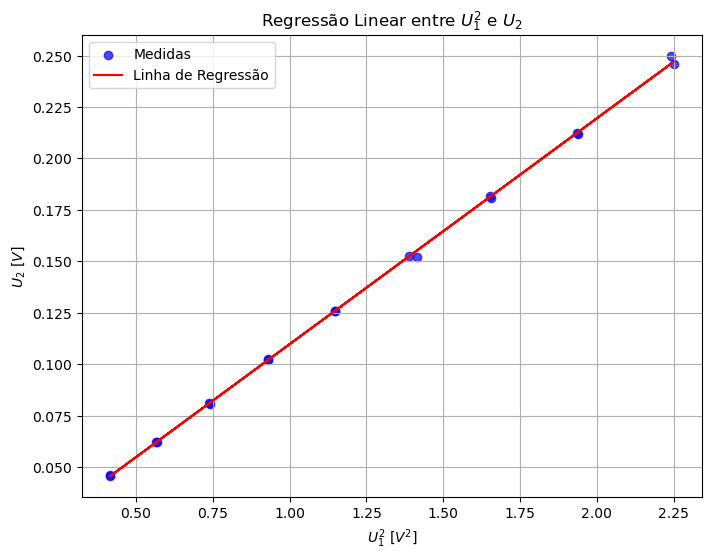

In [3]:
# Regressão linear entre U_1^2 e U_2
x = data["U_1^2 (V^2)"]
y = data["U_2 (V)"]

# Ajustar o modelo de regressão linear
result = linregress(x, y)
slope = result.slope
intercept = result.intercept
r_value = result.rvalue
p_value = result.pvalue
std_err = result.stderr
intercept_stderr = result.intercept_stderr

# Exibir os resultados
print(f"Equação da Regressão Linear: y = {slope:.2e} * x + {intercept:.2e}")
print(f"Coeficiente de Determinação (R²): {r_value**2:.4f}")
print(f"Erro Padrão: {std_err:.4f}")
print(f"P-valor: {p_value:.3e}")

# Visualizar os dados e a linha de regressão
plt.figure(figsize=(8, 6))
plt.scatter(x, y, label="Medidas", color="blue", alpha=0.7)
plt.xlabel("$U_1^2$ [$V^2$]")
plt.ylabel("$U_2$ [$V$]")
plt.title("Dispersão $U_1^2$ e $U_2$")
plt.legend()
plt.grid(True)
plt.show()

# Visualizar os dados e a linha de regressão
plt.figure(figsize=(8, 6))
plt.scatter(x, y, label="Medidas", color="blue", alpha=0.7)
plt.plot(x, slope * x + intercept, color="red", label="Linha de Regressão")
plt.xlabel("$U_1^2$ [$V^2$]")
plt.ylabel("$U_2$ [$V$]")
plt.title("Regressão Linear entre $U_1^2$ e $U_2$")
plt.legend()
plt.grid(True)
plt.show()

In [4]:
# Y2 = ( y_1 * y_2 * y_3 )^2 -> The Gain of the Amplifier Stage considering that its
# doesn't depend on the frequency
Y2 = (1.01*(10**6))**2 # Assuming Y2 as a constant

# Calculate U_0 and U^* with uncertainty propagation
U_0 = 1 / slope
U_0_err = std_err / (slope * slope)  # Propagating uncertainty for U_0 = 1/a

U_star = U_0 / Y2
U_star_err = U_0_err / Y2  # Propagating uncertainty for U^* = U_0 / Y^2

# Exibição dos resultados
results = {
    "Coeficiente Angular (a)": f"{slope:.3e} ± {std_err:.3e}",
    "Intercepto (b)": f"{intercept:.3e} ± {intercept_stderr:.3e}",
    "U_0": f"{U_0:.2e} ± {U_0_err:.1e}",
    "R²": f"{r_value**2:.4f}",
    "Valor p -> H0: slope = 0" : f"{p_value:.3e}",
}

display(results)

{'Coeficiente Angular (a)': '1.098e-01 ± 5.342e-04',
 'Intercepto (b)': '3.797e-05 ± 7.280e-04',
 'U_0': '9.11e+00 ± 4.4e-02',
 'R²': '0.9996',
 'Valor p -> H0: slope = 0': '8.350e-29'}

In [5]:
# Carregar o arquivo CSV
file_path = "./voltage_fluctoscopy_no_outliers.csv"  # Substitua pelo caminho correto
data_raw = pd.read_csv(file_path)

# Remover espaços extras nos nomes das colunas
data_raw.columns = data_raw.columns.str.strip()

# Criar intervalos de classes para C_n [nF]
bins = np.linspace(data_raw["C_n [nF]"].min(), data_raw["C_n [nF]"].max(), 6)
data_raw["Classes"] = pd.cut(data_raw["C_n [nF]"], bins)

# Agrupar por classes e calcular estatísticas (passando observed=False explicitamente)
frequency_table = data_raw.groupby("Classes", observed=False)["C_n [nF]"].agg(
    Média="mean",
    Mediana="median",
    Moda=lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan,
    Desvio_Padrão="std",
    Mínimo="min",
    Máximo="max",
    Frequência="count"
).reset_index()

# Adicionar labels e unidades
frequency_table.rename(columns={
    "Classes": "Classes $C_n$ [$nF$]",
    "Média": "Média [$nF$]",
    "Mediana": "Mediana [$nF$]",
    "Moda": "Moda [$nF$]",
    "Desvio_Padrão": "Desvio Padrão [$nF$]",
    "Mínimo": "Mínimo [$nF$]",
    "Máximo": "Máximo [$nF$]",
    "Frequência": "Frequência Absoluta"
}, inplace=True)

# Adicionar uma última linha com os dados referentes à tabela inteira
resumo_geral = {
    "Classes $C_n$ [$nF$]": "Geral",
    "Média [$nF$]": data_raw["C_n [nF]"].mean(),
    "Mediana [$nF$]": data_raw["C_n [nF]"].median(),
    "Moda [$nF$]": data_raw["C_n [nF]"].mode().iloc[0] if not data_raw["C_n [nF]"].mode().empty else np.nan,
    "Desvio Padrão [$nF$]": data_raw["C_n [nF]"].std(),
    "Mínimo [$nF$]": data_raw["C_n [nF]"].min(),
    "Máximo [$nF$]": data_raw["C_n [nF]"].max(),
    "Frequência Absoluta": len(data_raw["C_n [nF]"])
}

# Adicionar a linha "Geral" à tabela
frequency_table = pd.concat([frequency_table, pd.DataFrame([resumo_geral])], ignore_index=True)

# Limitar todos os elementos nas colunas numéricas à mesma precisão
colunas_a_formatar = ["Média [$nF$]", "Mediana [$nF$]", "Moda [$nF$]",
                      "Desvio Padrão [$nF$]", "Mínimo [$nF$]", "Máximo [$nF$]"]

# Use uma abordagem moderna com apply em vez de applymap para colunas específicas
frequency_table[colunas_a_formatar] = frequency_table[colunas_a_formatar].apply(lambda col: col.round(3))

# Exibir a tabela formatada no Colab
frequency_table.style.format({
    "Média [$nF$]": "{:.3f}",
    "Mediana [$nF$]": "{:.3f}",
    "Moda [$nF$]": "{:.3f}",
    "Desvio Padrão [$nF$]": "{:.3f}",
    "Mínimo [$nF$]": "{:.3f}",
    "Máximo [$nF$]": "{:.3f}",
    "Frequência Absoluta": "{:.0f}"
}).set_table_styles(
    [
        {"selector": "thead th", "props": [("background-color", "#D4E6F1"), ("color", "black"), ("font-weight", "bold")]},
        {"selector": "tbody td", "props": [("text-align", "center"), ("border", "1px solid black")]}
    ]
)


,Classes $C_n$ [$nF$],Média [$nF$],Mediana [$nF$],Moda [$nF$],Desvio Padrão [$nF$],Mínimo [$nF$],Máximo [$nF$],Frequência Absoluta
0,"(4.573, 18.652]",11.508,11.302,4.755,4.981,4.755,17.711,12
1,"(18.652, 32.732]",29.410,29.410,28.780,0.891,28.780,30.040,2
2,"(32.732, 46.811]",36.570,36.950,35.710,0.746,35.710,37.050,3
3,"(46.811, 60.891]",51.690,50.805,48.290,4.204,48.290,59.620,6
4,"(60.891, 74.97]",66.288,63.770,62.640,5.814,62.640,74.970,4
5,Geral,31.661,29.410,4.573,22.242,4.573,74.970,28


,x_n,y_n
0,19.279,2.504
1,56.462,3.118
2,34.746,2.880
3,15.718,2.444
4,169.434,4.679
5,20.708,2.535
6,59.852,3.169
7,79.529,3.546
8,28.003,2.722
9,15.964,2.448


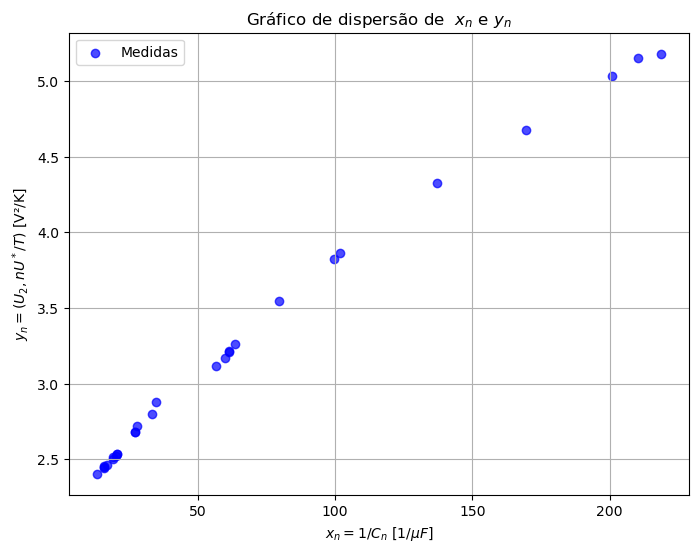

In [6]:
# Cálculo de x_n e y_n
data_raw["x_n"] = 1 / (data_raw["C_n [nF]"] * 10 ** -3)  # 1/C_n em unidades de 1/uF
data_raw["y_n"] = (data_raw["U_2 [mV]"] * 1e12 * U_star) / data_raw["T[K]"]  # y_n em V^2/K

tabela_aux = pd.DataFrame()
tabela_aux["x_n"] = data_raw["x_n"].round(3)
tabela_aux["y_n"] = data_raw["y_n"].round(3)

display(tabela_aux)

x_n = data_raw["x_n"]
y_n = data_raw["y_n"]

# Gráfico de Dispersão
plt.figure(figsize=(8, 6))
plt.scatter(x_n, y_n, label="Medidas", color="blue", alpha=0.7)
plt.xlabel("$x_n = 1 / C_n$ [$1 / \\mu F$]")
plt.ylabel("$y_n = (U_2,n U^* / T)$ [V²/K]")
plt.title("Gráfico de dispersão de  $x_n$ e $y_n$")
plt.legend()
plt.grid(True)
plt.show()

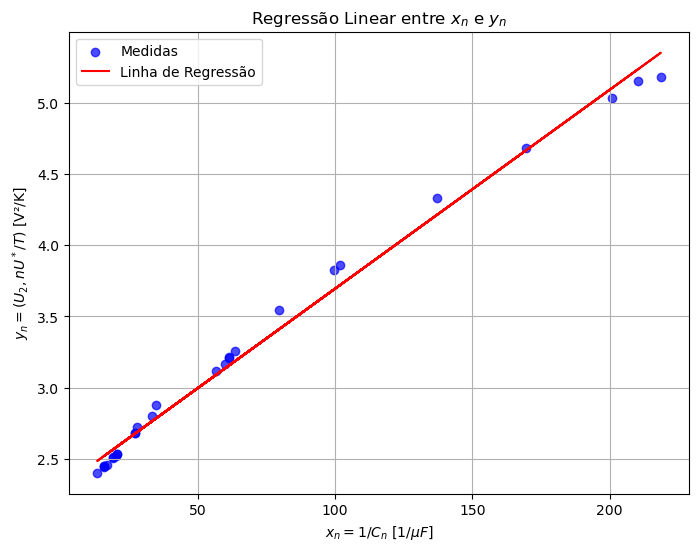

{'Coeficiente Angular (a)': '1.3943e-02 ± 2.4918e-04',
 'Intercepto (b)': '2.300e+00 ± 2.272e-02',
 'k_b (medido)': '1.39e-23 ± 2.5e-25',
 'R²': '0.9918',
 'k_b (real)': '1.38e-23',
 'Valor p -> H0: slope = 0': '1.246e-28',
 'Erro Relativo (%)': '1.0%'}

In [7]:
# Regressão linear
result = linregress(x_n, y_n)
slope = result.slope
intercept = result.intercept
r_value = result.rvalue
p_value = result.pvalue
std_err = result.stderr
intercept_stderr = result.intercept_stderr

# Exibir os resultados
# Calcular k_b e seu erro
k_b = slope * 10 ** -21
k_b_err = std_err * 10 ** -21

# Valor real de k_b e erro relativo
real_k_b = 1.3806488 * 10 ** -23  # Constante de Boltzmann verdadeira
relative_error = abs(real_k_b - k_b) / real_k_b * 100

# Exibição dos resultados
results = {
    "Coeficiente Angular (a)": f"{slope:.4e} ± {std_err:.4e}",
    "Intercepto (b)": f"{intercept:.3e} ± {intercept_stderr:.3e}",
    "k_b (medido)": f"{k_b:.2e} ± {k_b_err:.1e}",
    "R²": f"{r_value**2:.4f}",
    "k_b (real)": f"{real_k_b:.2e}",
    "Valor p -> H0: slope = 0" : f"{p_value:.3e}",
    "Erro Relativo (%)": f"{relative_error:.1f}%"
}
# Gráfico
plt.figure(figsize=(8, 6))
plt.scatter(x_n, y_n, label="Medidas", color="blue", alpha=0.7)
plt.plot(x_n, slope * x_n + intercept, color="red", label="Linha de Regressão")
plt.xlabel("$x_n = 1 / C_n$ [$1 / \\mu F$]")
plt.ylabel("$y_n = (U_2,n U^* / T)$ [V²/K]")
plt.title("Regressão Linear entre $x_n$ e $y_n$")
plt.legend()
plt.grid(True)
plt.show()

display(results)

In [8]:
# Teste de Hipótese
from scipy.stats import t

alpha = 0.05  # Nível de significância
df = len(x_n) - 2        # Graus de liberdade

# Valor crítico bilateral
t_critical = t.ppf(1 - alpha / 2, df)
print(f"Valor crítico t (bilateral): {t_critical}")

T0 = (k_b - real_k_b)/k_b_err
print(f"Estatísica T0: {T0}")

print("H0: k_b_medido = k_b")
print("H1: k_b_medido ≠ k_b")

if abs(T0) > t_critical:
    print("Rejeitamos H0")
else:
    print("Não rejeitamos H0")

print(f"Intervalo de Confiança para nível de significância de {alpha:.2f}")
print(f"{k_b - t_critical*k_b_err:.3e} < (k_b_medido = {k_b:.3e}) < {k_b + t_critical*k_b_err:.3e}")

Valor crítico t (bilateral): 2.055529438642871
Estatísica T0: 0.5498215595858931
H0: k_b_medido = k_b
H1: k_b_medido ≠ k_b
Não rejeitamos H0
Intervalo de Confiança para nível de significância de 0.05
1.343e-23 < (k_b_medido = 1.394e-23) < 1.446e-23


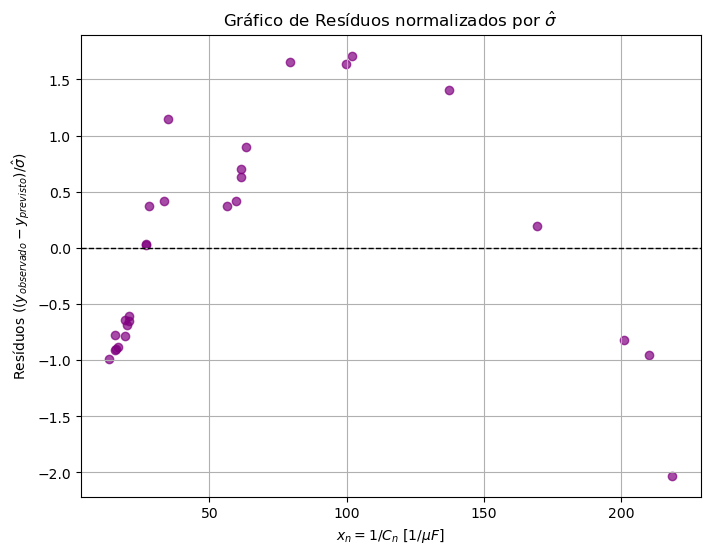

In [9]:
# Calcular os valores previstos
y_pred = slope * x_n + intercept

# Calcular os resíduos
residuals = y_n - y_pred
dp = np.sqrt(sum(residuals**2) / (len(residuals) - 2))

# Gráfico de resíduos
plt.figure(figsize=(8, 6))
plt.scatter(x_n, residuals/dp, color="purple", alpha=0.7)
plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.xlabel("$x_n = 1 / C_n$ [$1 / \\mu F$]")
plt.ylabel("Resíduos ($(y_{observado} - y_{previsto})/\\hat{\\sigma}$)")
plt.title("Gráfico de Resíduos normalizados por $\\hat{\\sigma}$")
plt.grid(True)
plt.show()

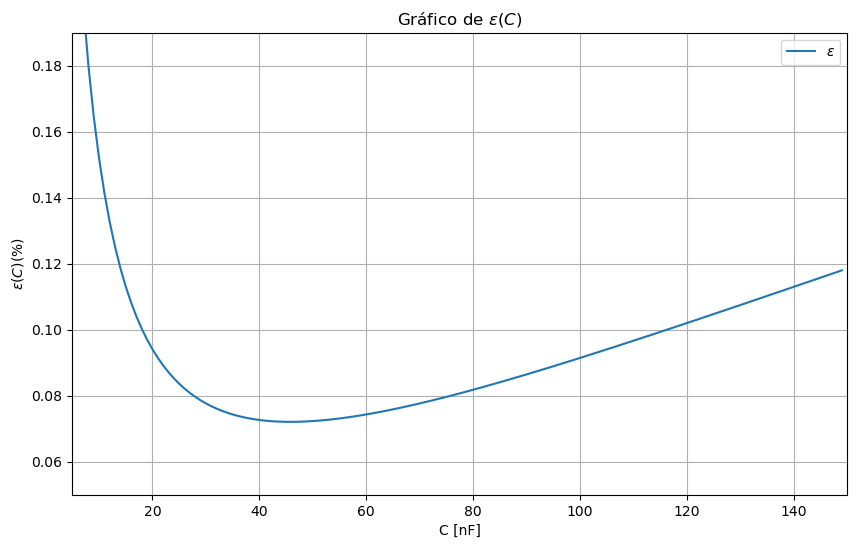

In [10]:
from mpmath import quad, mp

mp.dps = 10;

# Parâmetros constantes para Upsilon_NIA
G_0 = 1e5  # 10^5
τ = 3.94e-9  # 3.94e-9
f_0 = 1 / (2 * np.pi * τ)  # Aproximadamente 65MHz

R = 510  # 510 Ohms
r_g = 20  # 20 Ohms
R_f = 1e3  # 1k Ohm
C_f = 10e-12  # 10pF
C_g = 10e-6  # 10uF
R_g = 100  # 100 Ohm
R_f_prime = 10e3  # 10k Ohm
C_f_prime = 10e-12  # 10pF
R_1 = 2e3  # 2k Ohm
R_2 = 18e3  # 18k Ohm
R_av = 1.5e6  # 1.5Meg Ohm
C_av = 10e-6  # 10uF
R_v = 1e6  # 1Meg Ohm

# Definindo y_1, y_2 e y_3
y_1 = 1 + 2 * (R_f / r_g)
y_2 = -(R_f_prime / R_g)
y_3 = -(R_f_prime / R_g)

# Parâmetros para Y (produto de y_1, y_2 e y_3)
Y = y_1 * y_2 * y_3

I_0 = 1 - 1 / y_1  # Cálculo de I_0
tau_s = C_f * R_f / y_1  # Atualização de τ_s como C_f * R_f / y_1

# Parâmetros constantes para Upsilon_Delta
tau_g = C_g * R_f_prime  # Definindo τ_g

# Função N(ω) para Upsilon_NIA
def N(ω):
    return 1 + ω**2 * tau_s**2

# Função para Upsilon_NIA(ω)
def Upsilon_NIA(ω):
    term1 = N(ω)**2
    term2 = (G_0**-1 * N(ω) + (1 / y_1 + ω**2 * tau_s**2))**2
    term3 = (ω * tau_s)**2 * (τ / tau_s * N(ω) + I_0)**2
    return term1 / (term2 + term3)

# Função para Upsilon_Delta(ω)
def Upsilon_Delta(ω):
    Λ_0 = R_g / R_f_prime
    M = 1 + Λ_0
    term1 = (ω * tau_g)**2
    term2 = (1 + G_0**-1 - M * ω**2 * τ * tau_g)**2
    term3 = (ω * tau_g)**2 * (τ / tau_g + Λ_0 + G_0**-1 * M)**2
    return term1 / (term2 + term3)

# Função para Upsilon_IA(ω)
tau_f_prime = C_f * R_f_prime  # Definindo τ_f'
tau_fg = C_f * R_g  # Definindo τ_fg

def Upsilon_IA(ω):
    M = 1 + R_g / R_f_prime
    term1 = (ω * tau_g)**2
    term2 = ((1 + G_0**-1) * (1 - ω**2 * tau_fg * tau_g) - M * ω**2 * τ * tau_g - ω**2 * τ * tau_f_prime)**2
    term3 = (ω * tau_g)**2 * (τ / tau_g + (R_g / R_f_prime) + G_0**-1 * M + (tau_f_prime / tau_g) * (G_0**-1 + 1) - ω**2 * τ * tau_fg)**2
    return term1 / (term2 + term3)

# Função para Upsilon(ω)
def Upsilon(ω):
    return Upsilon_NIA(ω) * Upsilon_Delta(ω) * Upsilon_IA(ω)

# Função para ε(C)
def Z(C, R, Y):
    # Definir a função de integração para o denominador da integral
    integrand1 = lambda ω: Upsilon(ω) * (1 / (1 + (ω * R * C)**2))
    integrand2 = lambda ω: 1 / (1 + (ω * R * C)**2)

    # Realizar as integrações numéricas
    integral1 = quad(integrand1, [0, mp.inf])
    integral2 = quad(integrand2, [0, mp.inf])

    # Calcular ε(C)
    return (integral1 / (Y**2 * integral2))

# Valores de C e cálculo de y_epsilon
C_values = np.arange(5e-9, 150e-9, 1e-9)  # Intervalo de C
y_epsilon = [1 - (Z(C, R, Y)) for C in C_values]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(C_values * 1e9, y_epsilon, label="$\\epsilon$", linestyle='solid')
plt.xlabel("C [nF]")
plt.ylabel("$\\epsilon(C) (\\%)$")
plt.title("Gráfico de $\\epsilon (C)$")
plt.xlim(5, 150)
plt.ylim(0.05, 0.19)
plt.grid()
plt.legend()
plt.show()

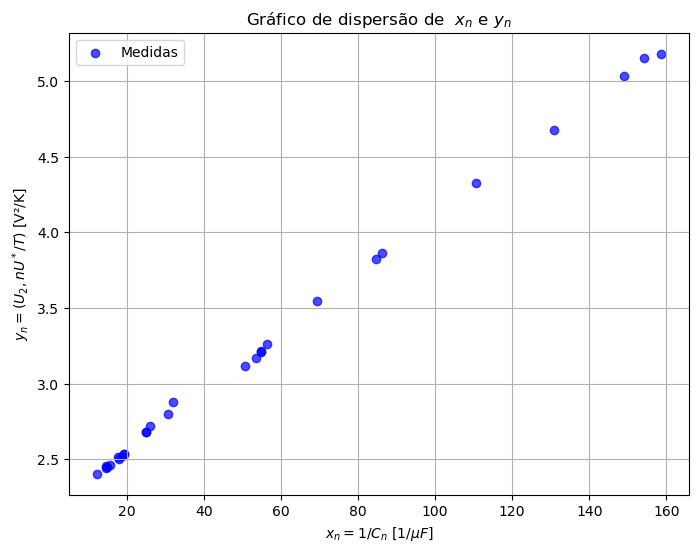

In [11]:
# Cálculo de x_n e y_n
data_raw["x_n"] = data_raw["C_n [nF]"].apply(lambda C: ((Z(C*10**(-9), R, Y)) / (C * 10**-3)))
data_raw["y_n"] = (data_raw["U_2 [mV]"] * 1e12 * U_star) / data_raw["T[K]"]  # y_n em V^2/K

x_n = data_raw["x_n"].astype(float).values # Convert x_n to a NumPy array of floats
y_n = data_raw["y_n"].astype(float).values # Convert y_n to a NumPy array of floats

# Gráfico de Dispersão
plt.figure(figsize=(8, 6))
plt.scatter(x_n, y_n, label="Medidas", color="blue", alpha=0.7)
plt.xlabel("$x_n = 1 / C_n$ [$1 / \\mu F$]")
plt.ylabel("$y_n = (U_2,n U^* / T)$ [V²/K]")
plt.title("Gráfico de dispersão de  $x_n$ e $y_n$")
plt.legend()
plt.grid(True)
plt.show()

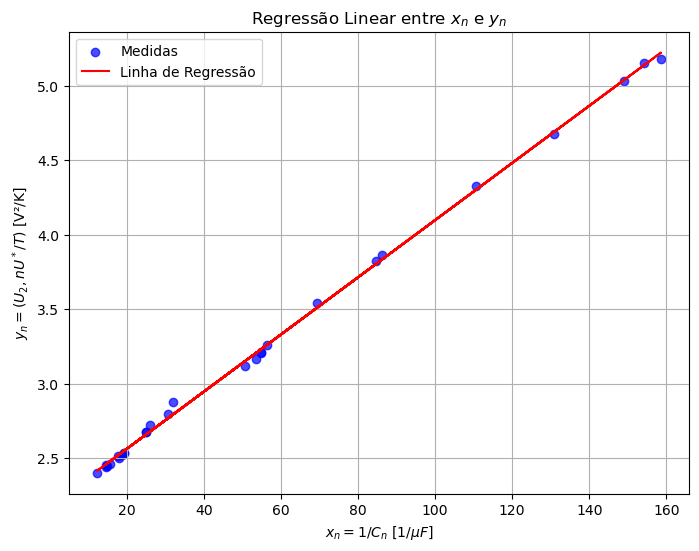

{'Coeficiente Angular (a)': '1.918e-02 ± 1.194e-04',
 'Intercepto (b)': '2.181e+00 ± 8.479e-03',
 'k_b (medido)': '1.918e-23 ± 1.19e-25',
 'R²': '0.9990',
 'k_b (real)': '1.38e-23',
 'Valor p -> H0: slope = 0': '1.707e-40',
 'Erro Relativo (%)': '38.9%'}

In [12]:
# Regressão linear
result = linregress(x_n, y_n)
slope = result.slope
intercept = result.intercept
r_value = result.rvalue
p_value = result.pvalue
std_err = result.stderr
intercept_stderr = result.intercept_stderr

# Exibir os resultados
# Calcular k_b e seu erro
k_b = slope * 10 ** -21
k_b_err = std_err * 10 ** -21

# Valor real de k_b e erro relativo
real_k_b = 1.3806488 * 10 ** -23  # Constante de Boltzmann verdadeira
relative_error = abs(real_k_b - k_b) / real_k_b * 100

# Exibição dos resultados
results = {
    "Coeficiente Angular (a)": f"{slope:.3e} ± {std_err:.3e}",
    "Intercepto (b)": f"{intercept:.3e} ± {intercept_stderr:.3e}",
    "k_b (medido)": f"{k_b:.3e} ± {k_b_err:.2e}",
    "R²": f"{r_value**2:.4f}",
    "k_b (real)": f"{real_k_b:.2e}",
    "Valor p -> H0: slope = 0" : f"{p_value:.3e}",
    "Erro Relativo (%)": f"{relative_error:.1f}%"
}
# Gráfico
plt.figure(figsize=(8, 6))
plt.scatter(x_n, y_n, label="Medidas", color="blue", alpha=0.7)
plt.plot(x_n, slope * x_n + intercept, color="red", label="Linha de Regressão")
plt.xlabel("$x_n = 1 / C_n$ [$1 / \\mu F$]")
plt.ylabel("$y_n = (U_2,n U^* / T)$ [V²/K]")
plt.title("Regressão Linear entre $x_n$ e $y_n$")
plt.legend()
plt.grid(True)
plt.show()

display(results)

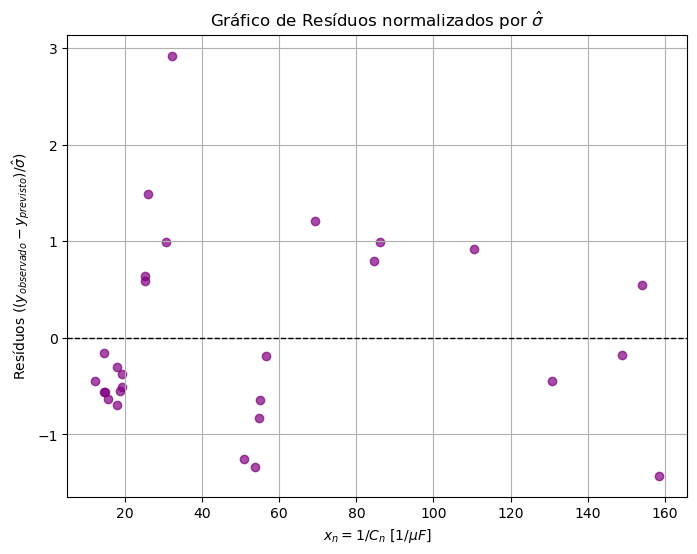

In [13]:
# Calcular os valores previstos
y_pred = slope * x_n + intercept

# Calcular os resíduos
residuals = y_n - y_pred
dp = np.sqrt(sum(residuals**2) / (len(residuals) - 2))

# Gráfico de resíduos
plt.figure(figsize=(8, 6))
plt.scatter(x_n, residuals/dp, color="purple", alpha=0.7)
plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.xlabel("$x_n = 1 / C_n$ [$1 / \\mu F$]")
plt.ylabel("Resíduos ($(y_{observado} - y_{previsto})/\\hat{\\sigma}$)")
plt.title("Gráfico de Resíduos normalizados por $\\hat{\\sigma}$")
plt.grid(True)
plt.show()